# Imports

In [3]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import tensorflow as tf 

from imblearn.over_sampling import SMOTE

# Load Training Data

In [4]:
df = pd.read_csv("./Data/trainingData.csv")

# Preprocess Categorical Data

We need to one hot encode our categorical variables to use in the random forest classifier. We can do so using column transformers. 

In [5]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['sex',
                        'hypertension',
                        'heart_disease',
                        'ever_married',
                        'work_type',
                        'Residence_type',
                        'smoking_status',
                        'age_group',
                        'bmi_group']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('Numeric', 'passthrough', numeric_features),
    ('Categorical', categorical_transformer, categorical_features)
])

# Balance the target and make train, validation, and test splits

In [6]:
y = df.pop('stroke').to_numpy()
X = preprocessor.fit_transform(df)

When building a classifier it is very important to check whether the classes in your training data are balanced.

In [9]:
# Check the class balance
100*(sum(y)/len(y))

4.260958205912335

Only 4.3% of the subjects in our dataset have a class of stroke, the rest are all no-stroke. This will most likely cause our model to perform very poorly. Let's try!

In [10]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.2) # 20% testing 80% training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25) # 25% validation 80% training

# Non-deep-learning method

# Random Forest classifier

In [11]:
# Initialize and train the model
RF = RandomForestClassifier(n_estimators=300)
RF = RF.fit(X_train, y_train)

In [12]:
preds = RF.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        41

    accuracy                           0.96       981
   macro avg       0.48      0.50      0.49       981
weighted avg       0.92      0.96      0.94       981



As we expected our model only returns predictions that patients in the test data set do not have a stroke, this is due to the heavyily imbalanced class of no-stroke to stroke. Now let's employ a re-sampling technique to address this issue. 

In [13]:
# There is a heavy class imbalance for people who do not have stroke compared to people who do.
# Thus for our classification model to not keep predicting the dominating class we must resample to balance our data
# We will use an over-sampling of the minority class using the method Synthetic Minority Oversampling Technique (SMOTE)
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [14]:
X_train, X_test, y_train, y_test, = train_test_split(X_smote, y_smote, test_size = 0.2) # 20% testing 80% training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25) # 25% validation 80% training

In [15]:
# Initialize and train the model
RF = RandomForestClassifier(n_estimators=300)
RF = RF.fit(X_train, y_train)

In [16]:
preds = RF.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       942
           1       1.00      0.96      0.98       937

    accuracy                           0.98      1879
   macro avg       0.98      0.98      0.98      1879
weighted avg       0.98      0.98      0.98      1879



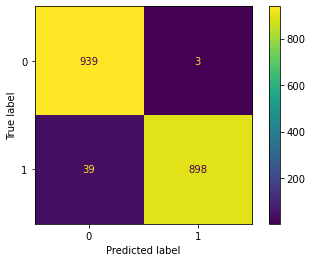

In [17]:
ax=plot_confusion_matrix(RF, X_test, y_test)

Okay, this is significantly better! After addressing the class imbalance the performance of our model is very good. The confusion matrix shows the true positives (898), true negatives (939), false negatives (39) and the false positives (3). 

# Deep-learning Approach

Let's see if we can do better using a deep-learning model.

# Process the data into correct batches

In [18]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [19]:
train = train.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(32).prefetch(1)
val = val.batch(32).prefetch(1)

In [20]:
# Check the input shape
train

<PrefetchDataset shapes: ((None, 31), (None,)), types: (tf.float64, tf.int64)>

# Define the model

In [32]:
# Define a very simple neural network with a dropout layer for regularization (this simulates L2 regularization)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (31)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units = 1024, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units = 1, activation="sigmoid")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               16384     
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 1,067,009
Trainable params: 1,067,009
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compile the model using the adam optimizer
history = model.fit(train, epochs=200, batch_size=32, validation_data=val)

Epoch 1/200
177/177 [==============================] - 3s 17ms/step - loss: 0.8557 - accuracy: 0.7132 - val_loss: 0.5391 - val_accuracy: 0.7014
Epoch 2/200
177/177 [==============================] - 3s 17ms/step - loss: 0.4890 - accuracy: 0.7457 - val_loss: 0.4770 - val_accuracy: 0.7578
Epoch 3/200
177/177 [==============================] - 3s 18ms/step - loss: 0.4791 - accuracy: 0.7524 - val_loss: 0.4649 - val_accuracy: 0.7674
Epoch 4/200
177/177 [==============================] - 3s 18ms/step - loss: 0.4600 - accuracy: 0.7645 - val_loss: 0.4676 - val_accuracy: 0.7791
Epoch 5/200
177/177 [==============================] - 3s 17ms/step - loss: 0.4621 - accuracy: 0.7671 - val_loss: 0.4480 - val_accuracy: 0.7866
Epoch 6/200
177/177 [==============================] - 3s 17ms/step - loss: 0.4476 - accuracy: 0.7735 - val_loss: 0.4451 - val_accuracy: 0.7871
Epoch 7/200
177/177 [==============================] - 3s 17ms/step - loss: 0.4400 - accuracy: 0.7794 - val_loss: 0.4361 - val_accuracy:

In [34]:
# Evaluate the model on the test data
model.evaluate(test)

59/59 [==============================] - 0s 5ms/step - loss: 0.1556 - accuracy: 0.9643


[0.1556152105331421, 0.9643427133560181]

96% accuracy, not bad! Let's look at our loss across the epochs

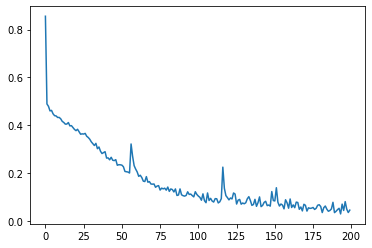

In [40]:
losses = pd.Series(history.history['loss'])
losses.plot.line()

Looks like at the end it was bouncing around a lot. To improve the performance we may need to dynamically change the learning rate of the optimizer as we train.

In [41]:
# Let's pull out the labels from the test set so that we can generate a confusion matrix
labels = []
for items in test:
    for item in items[1]:
        labels.append(item.numpy())

In [42]:
tf.math.confusion_matrix(labels, model.predict_classes(test),).numpy()

array([[877,  65],
       [  2, 935]], dtype=int32)

This is also a good model, but the accuracy of the random forest classifer was 98 percent which is a little bit better. However, the deep-learning model does better with reducing the false negatives (2), which may be of more importance when predicting stroke compared to doing better at false positives (65).

# Conclusion

The initial random forest classifier was the best classifier we built. The deep learning did very well as well, but it was not the best in terms of raw performance. However, if false negatives are a clinical concern then it may be advantageous to select the deep-learning model. The deep-learning model is only a simple model and can be improved further by adding more layers and tuning somee hyper-paramters.